In [27]:
from __future__ import print_function
import math
import torch
import torch.nn as nn
import torch.nn.init as init

import matplotlib.pyplot as plt
import argparse
# import os
import shutil
import warnings
from copy import deepcopy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision
import numpy as np
from prune_layer import *
import torch.nn as nn
import time


__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            PruneLinear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            PruneLinear(512, 512),
            nn.ReLU(True),
            PruneLinear(512, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = PrunedConv(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def get_num_correct(pred,labels):
    return pred.argmax(dim=1).eq(labels).sum().item()

def init_weights(m):
    if type(m)==nn.Linear or type(m)==nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


def Net():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))
    
    
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),

])
train_set=torchvision.datasets.CIFAR10(
    root='~/work/data/Xian/cifar10',
    train=True,
    download=True,
    transform=transform_train)


test_set=torchvision.datasets.CIFAR10(
    root='~/work/data/Xian/cifar10',
    train=False,
    download=True,
    transform=transform_test)



device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

def train_(train_set,test_set,layer_name, q, PATH = "sdfadsfag.pt", batch_size_train = 128, momentum = 0, mask_bit_position = [1]*16, lr = 0.1, epochs = 10):
    torch.manual_seed(1)
    train_loader=torch.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=False, pin_memory=True,num_workers=2)
    test_loader=torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, pin_memory=True,num_workers=2)

    torch.manual_seed(1)
    network= Net().to(device)
    network.apply(init_weights)
    layer_num =0
    for n, m in network.named_modules():
        if isinstance(m,PrunedConv):
            if layer_num in layer_name:
                 m.prune_by_percentage(q = q)
            layer_num +=1
        if isinstance(m,PruneLinear):
            if layer_num in layer_name:
                 m.prune_by_percentage(q = q)
            layer_num +=1                

    optimizer = optim.SGD(network.parameters(), lr=lr, momentum = 0.9, weight_decay=0.0005)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

    acc_train=[]
    acc_test=[]
    acc = 0

    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        network.train()
        count_in = 0

        for batch in train_loader: #Get batch

            count_in = count_in + 1
            images,labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            #Do bit maskinn
            layer_num  = 0
            for name, model in network.named_modules():
                if isinstance(model, PrunedConv):
                    if layer_num in layer_name:
                        model.conv.weight.data.mul_(model.mask)
                    layer_num +=1
                elif isinstance(model, PruneLinear):
                    if layer_num in layer_name:
                        model.linear.weight.data.mul_(model.mask)
                    layer_num +=1
                else:
                    pass

            preds=network(images) #pass batch to network
            correct = get_num_correct(preds, labels)
            loss = criterion(preds,labels) #Calculate loss
            loss.backward() #Calculate gradients
            optimizer.step() #Update weights
            total_correct+=correct
            
        print("epoch: ", epoch,  "total_correct: ", total_correct)
        print("training accuracy: ", total_correct/len(train_set))
        acc_train.append(deepcopy(float(total_correct)/len(train_set)))

        with torch.no_grad():
            correct_test=0
            for batch_test in test_loader: #Get batch
                images_test,labels_test = batch_test
                images_test, labels_test = images_test.to(device), labels_test.to(device)
                preds_test=network(images_test) #pass batch to network
                correct_test += get_num_correct(preds_test, labels_test)
            print("testing accuracy: ", correct_test / len(test_set))
            if epoch == epochs - 1:
                print(correct_test / len(test_set))
                acc = correct_test / len(test_set)
                torch.save(network.state_dict(), PATH)
                  
            acc_test.append(deepcopy(float(correct_test)/len(test_set)))
        scheduler.step()
    
    return acc






list_q = [5]
list_acc = []
list_layers =[9]
for layer_name in list_layers:
    for q in list_q:
        acc = train_(train_set,test_set,PATH = "VGG11_lr01_layer_9_q1",layer_name=[layer_name],lr = 0.1, q=q,epochs = 50)
        list_acc += [acc]
    print(list_acc)
        
import pandas as pd
list_acc = np.array(list_acc).reshape((len(list_layers),-1))
df = pd.DataFrame (list_acc)
print(df)
## save to xlsx file
# filepath = './results/VGG11_weight_jlab.csv'

# df.to_csv(filepath,index = False)



Files already downloaded and verified
Files already downloaded and verified
Run on GPU...
epoch:  0 total_correct:  9618
training accuracy:  0.19236
testing accuracy:  0.2778
epoch:  1 total_correct:  16418
training accuracy:  0.32836
testing accuracy:  0.3982
epoch:  2 total_correct:  21607
training accuracy:  0.43214
testing accuracy:  0.4858
epoch:  3 total_correct:  25460
training accuracy:  0.5092
testing accuracy:  0.565
epoch:  4 total_correct:  29665
training accuracy:  0.5933
testing accuracy:  0.6316
epoch:  5 total_correct:  31931
training accuracy:  0.63862
testing accuracy:  0.6384
epoch:  6 total_correct:  33700
training accuracy:  0.674
testing accuracy:  0.6937
epoch:  7 total_correct:  35330
training accuracy:  0.7066
testing accuracy:  0.7238
epoch:  8 total_correct:  36309
training accuracy:  0.72618
testing accuracy:  0.7501
epoch:  9 total_correct:  37530
training accuracy:  0.7506
testing accuracy:  0.7497
epoch:  10 total_correct:  37858
training accuracy:  0.757

In [14]:
torch.manual_seed(1)
network= Net().to(device)
network.load_state_dict(torch.load("VGG11_lr01_layer_7_q1"))

<All keys matched successfully>

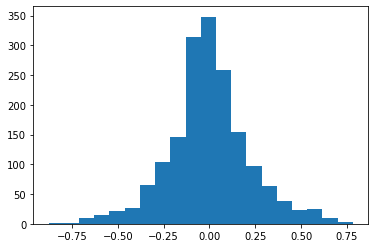

In [24]:
layer_name = [1]
layer_num = 1
for name, model in network.named_modules():
    if isinstance(model, PrunedConv):
        if layer_num in layer_name:
            weight = model.conv.weight.data.cpu().detach().numpy().reshape(-1)
            _ = plt.hist(weight, bins=20)
        layer_num +=1
    elif isinstance(model, PruneLinear):
        if layer_num in layer_name:
            weight = model.linear.weight.data.cpu().detach().numpy().reshape(-1)
            _ = plt.hist(weight, bins=20)
        layer_num +=1
    else:
        pass